# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [1]:
from sklearn.metrics import f1_score
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

### Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 100

# Training
BATCH_SIZE = 64
NUM_EPOCHS = 300
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-4
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device="cpu"


### Dataset


In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR100(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR100(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = train_set.classes


Files already downloaded and verified
Files already downloaded and verified


### Model

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        
        self.fc1 = nn.Linear(64 * 4 * 4, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.relu4 = nn.ReLU()
        
        self.fc2 = nn.Linear(256, 100)

    def forward(self, x):
        x = self.pool(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool(self.relu3(self.bn3(self.conv3(x))))
        
        x = x.view(-1, 64 * 4 * 4)
        
        x = self.relu4(self.dropout1(self.fc1(x)))
        x = self.fc2(x)
        return x


In [6]:
model = ConvNet()
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (relu4): ReLU()
  (fc2): Linear(in_features=256, out_features=100, bias=True)
)

### Optimizer

In [7]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
from torch.optim import lr_scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [8]:
def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################

    output = model(image)
    loss = criterion(output, target)

    ###############################################################

    return output, loss

In [9]:
##################### Write your answer here ##################
# Define the loss function

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=1.0):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, y_pred, y_true):
        """
        y_pred: raw scores (logits) for each class. [batch_size, num_classes]
        y_true: ground truth labels. [batch_size]
        """
        # Convert y_true labels into one-hot encoding
        y_true_onehot = torch.zeros(y_pred.size(), device=y_pred.device).scatter_(1, y_true.unsqueeze(1).long(), 1)
        
        # Calculate softmax over y_pred for calculating probabilities
        probs = F.softmax(y_pred, dim=1)
        
        # Calculate focal loss
        focal_loss = -self.alpha * (y_true_onehot * torch.log(probs) * (1 - probs) ** self.gamma).sum(dim=1).mean()
        
        return focal_loss


#criterion = nn.L1Loss()
criterion = nn.CrossEntropyLoss()
#criterion = FocalLoss(gamma=0.5)
#criterion = FocalLoss(gamma=2.0)

def one_hot_encoding(target, num_classes):
    return F.one_hot(target, num_classes=num_classes).float()


###############################################################

In [10]:

def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
   # model.eval()
   # with torch.no_grad():
    output = model(image)
    loss = criterion(output, target)
        
        
    ###############################################################

    return output, loss

### Model Training

In [11]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []
start_time = time.time()  # 记录开始时间
all_preds = []
all_targets = []
# 日志文件
log_file = 'training_log.txt'
for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):
        image = image.to(device)
        target = target.to(device)
 
        outputs, loss = train_batch(model, image, target)
     
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    #########
    all_preds.extend(preds.cpu().numpy())
    all_targets.extend(target.cpu().numpy())
    f1 = f1_score(all_targets, all_preds, average='weighted')
    print(f"f1 score in {epoch}th epoch is {f1}")

############
    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            ##################
          #  target_one_hot = one_hot_encoding(target, 10)  # 转换成 one-hot 编码
            outputs, loss = test_batch(model, image, target)
          #  outputs, loss = test_batch(model, image, target_one_hot)  # 使用 one-hot 编码后的目标
            #######################
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())
    with open(log_file, 'a') as f:
        f.write(f'Epoch {epoch+1}/{NUM_EPOCHS}\n')
        f.write(f'Train Accuracy: {epoch_acc:.4f}%\n')
        f.write(f'Test Accuracy: {val_acc:.4f}%\n')
        f.write('\n')

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))
            
end_time = time.time()  # 记录结束时间
duration = end_time - start_time  # 计算训练时间
print(f"训练模型用时：{duration}秒")
 

Epoch: 1/300 Train Loss: 0.0719 Acc: 0.0156
f1 score in 0th epoch is 0.0
Begin test......
Test Loss: 0.0713 Acc: 0.0366
Epoch: 2/300 Train Loss: 0.0708 Acc: 0.0307
f1 score in 1th epoch is 0.020833333333333332
Begin test......
Test Loss: 0.0702 Acc: 0.0619
Epoch: 3/300 Train Loss: 0.0697 Acc: 0.0435
f1 score in 2th epoch is 0.010416666666666666
Begin test......
Test Loss: 0.0686 Acc: 0.0745
Epoch: 4/300 Train Loss: 0.0684 Acc: 0.0545
f1 score in 3th epoch is 0.0390625
Begin test......
Test Loss: 0.0672 Acc: 0.0854
Epoch: 5/300 Train Loss: 0.0672 Acc: 0.0602
f1 score in 4th epoch is 0.075
Begin test......
Test Loss: 0.0657 Acc: 0.0950
Epoch: 6/300 Train Loss: 0.0663 Acc: 0.0660
f1 score in 5th epoch is 0.07465277777777778
Begin test......
Test Loss: 0.0652 Acc: 0.1017
Epoch: 7/300 Train Loss: 0.0657 Acc: 0.0688
f1 score in 6th epoch is 0.06045918367346938
Begin test......
Test Loss: 0.0644 Acc: 0.1059
Epoch: 8/300 Train Loss: 0.0652 Acc: 0.0728
f1 score in 7th epoch is 0.060491071428571

### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [12]:
inputs, classes = next(iter(test_dataloader))
input = inputs[0]

In [13]:
##################### Write your answer here ##################
# input: image, model
# outputs: predict_label, probabilities
# predict_label is the index (or label) of the class with the highest probability from the probabilities.
###############################################################
input_tensor = input.unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    probabilities = F.softmax(output, dim=1)
    predict_label = torch.argmax(probabilities)
# predict_label = 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


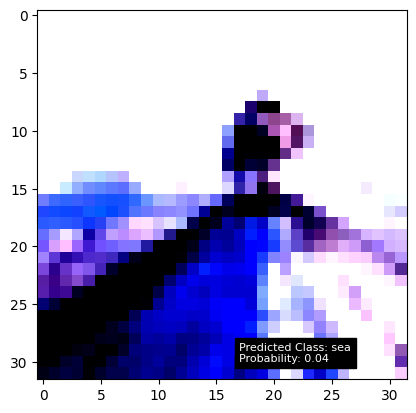

Print probabilities for each class:
apple: 0.0037
aquarium_fish: 0.0025
baby: 0.0065
bear: 0.0065
beaver: 0.0050
bed: 0.0106
bee: 0.0019
beetle: 0.0056
bicycle: 0.0119
bottle: 0.0141
bowl: 0.0071
boy: 0.0056
bridge: 0.0328
bus: 0.0101
butterfly: 0.0019
camel: 0.0076
can: 0.0113
castle: 0.0305
caterpillar: 0.0022
cattle: 0.0032
chair: 0.0230
chimpanzee: 0.0036
clock: 0.0199
cloud: 0.0315
cockroach: 0.0161
couch: 0.0120
crab: 0.0050
crocodile: 0.0033
cup: 0.0120
dinosaur: 0.0103
dolphin: 0.0124
elephant: 0.0056
flatfish: 0.0162
forest: 0.0032
fox: 0.0020
girl: 0.0044
hamster: 0.0056
house: 0.0153
kangaroo: 0.0046
keyboard: 0.0247
lamp: 0.0183
lawn_mower: 0.0172
leopard: 0.0033
lion: 0.0011
lizard: 0.0045
lobster: 0.0043
man: 0.0074
maple_tree: 0.0034
motorcycle: 0.0083
mountain: 0.0339
mouse: 0.0050
mushroom: 0.0022
oak_tree: 0.0052
orange: 0.0013
orchid: 0.0065
otter: 0.0106
palm_tree: 0.0145
pear: 0.0034
pickup_truck: 0.0105
pine_tree: 0.0140
plain: 0.0167
plate: 0.0187
poppy: 0.0010
p

In [14]:
predicted_class = class_names[predict_label.item()]
predicted_probability = probabilities[0][predict_label.item()]
image = input.numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
plt.show()

# Print probabilities for each class
print('Print probabilities for each class:')
for i in range(len(class_names)):
    print(f'{class_names[i]}: {probabilities[0][i].item():.4f}')

In [15]:
for i in np.array(training_acc):
    print(f"{i:.5f}",end=',')
print("\n\n")
for i in np.array(testing_acc):
    print(f"{i:.5f}",end=',')

0.01564,0.03070,0.04350,0.05448,0.06022,0.06600,0.06884,0.07284,0.07460,0.07812,0.08258,0.08380,0.08390,0.08950,0.08778,0.08958,0.09106,0.09346,0.09352,0.09458,0.09384,0.09360,0.09718,0.09528,0.09818,0.09640,0.09702,0.09724,0.09540,0.09628,0.09938,0.09746,0.09902,0.09732,0.09816,0.09796,0.09924,0.09820,0.09776,0.09890,0.10058,0.09770,0.10054,0.09888,0.09722,0.09722,0.09854,0.09892,0.09900,0.09898,0.09688,0.09954,0.09798,0.09932,0.09944,0.10076,0.09740,0.10100,0.09856,0.09692,0.09722,0.10046,0.09880,0.09848,0.09848,0.09676,0.09920,0.09992,0.09820,0.09814,0.09926,0.09856,0.10000,0.10002,0.09980,0.09766,0.09746,0.09866,0.09876,0.10022,0.09956,0.09820,0.09730,0.09750,0.09992,0.09672,0.09684,0.09996,0.09910,0.09934,0.09968,0.09950,0.09910,0.09908,0.09956,0.09750,0.09818,0.09840,0.09744,0.09960,0.10048,0.10012,0.09810,0.09888,0.09844,0.10056,0.09818,0.09896,0.09924,0.09960,0.09622,0.09968,0.09674,0.09782,0.09802,0.09956,0.09778,0.09882,0.09760,0.10000,0.09876,0.09916,0.09940,0.09852,0.09816,

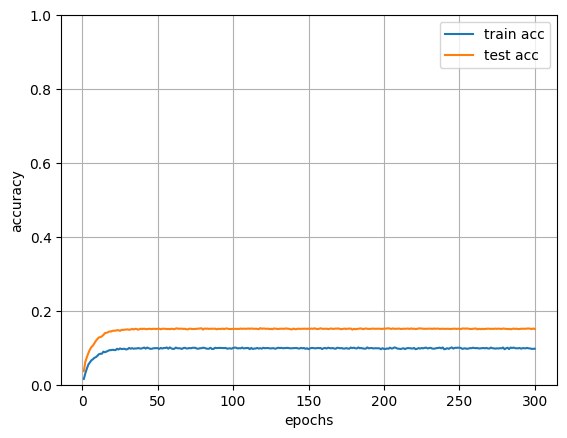

In [16]:
fig, ax = plt.subplots()
epochs = list(range(1, 301))
line1 = ax.plot(epochs, np.array(training_acc), label="train acc")
line2 = ax.plot(epochs, np.array(testing_acc), label="test acc")
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')
ax.grid(True)
ax.set_ylim(0, 1)
ax.legend()
plt.show()